# Práctica 2 - Modelos Probabilı́sticos, Filtros Discretos y Filtros de Partı́culas

**Profesor**: Prof. Dr. Ignacio Mas

**Fecha límite de entrega**: 28/09/24, 23:54hs.

---

In [ ]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

## 1. Muestreo de distribuciones de probabilidad

Implementar tres funciones en Python que generen muestras de una distribución normal $\mathcal{N} \sim (\mu, \sigma^2)$. Los parámetros de entrada de dichas funciones son la media $\mu$ y la varianza $\sigma^2$ de dicha distribución.Como única fuente de aleatoriedad, utilizar muestras de una distribución uniforme.

In [2]:
def plot_histogram(x, mu=0, sigma=1, nbins=100, label=None):
    fig, ax = plt.subplots()
    ax.hist(x, bins=nbins, density=True, label=label)
    _, x_gauss = np.histogram(x, bins=nbins, density=True)
    y_gauss = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x_gauss - mu)**2 / (2 * sigma**2))
    ax.plot(x_gauss, y_gauss, '--', label='Ground truth')
    ax.grid(True)
    ax.legend()

mu, sigma = 0, 1 # mean and standard deviation
N = 10000 # number of samples
nbins = 100 # number of bins in the histogram

1. En la primer función, generar las muestras de la distribución normal sumando muestras de 12 distribuciones uniformes.

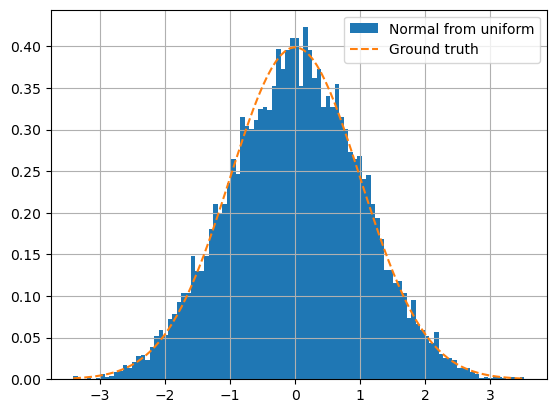

In [3]:
def normal_from_uniform(mu=0, sigma=1, N=1000, iters=10):
    
    """
        Función para obtener muestras de la distribución normal a partir de 
        la distribución uiforme.
        
        mu: media de la normal
        sigma: varianza de la normal
        N: cantidad de muestras a generar
        iters: cantidad de distribuciones uniformes
        
        return: Devuelve un numpy array de N puntos con muestras de la distribución.
    """
    
    # Generamos una 
    b = sigma / 2 * np.sqrt(12 / iters)
    x = np.zeros(N) # array de n ceros
    for _ in range(iters):
        x += -b + 2 * b * np.random.rand(N)
    return x + mu

iters = 12
x = normal_from_uniform(mu=mu, sigma=sigma, N=N, iters=iters)
plot_histogram(x, mu=mu, sigma=sigma, nbins=nbins, label='Normal from uniform')

2. En la segunda función, usar “muestreo con rechazo”

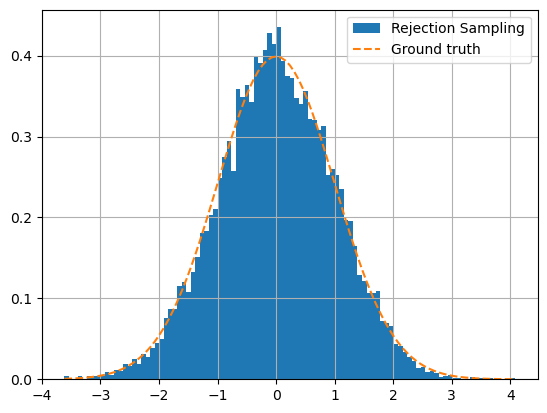

In [4]:
def normal_rejection_sampling(mu=0, sigma=1, N=1):
    """
        Función para obtener muestras de la distribución normal con el método
        de muestreo con rechazo.
        
        mu: media de la normal
        sigma: varianza de la normal
        n: cantidad de puntos que devuelve 
        
        return: Devuelve un numpy array de n puntos con muestras de la distribución.
    """
    
    f = lambda x: 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-(x-mu)**2/2/sigma**2) # pdf de la gaussiana
    fmax = f(mu) # valor máximo de la gaussiana
    i = 0 # cantidad de muestras hasta el momento
    x = np.array([]) # vector para guardar las muestras conservadas
    
    # Main loop: continuar la iteración hasta tener n muestras
    while i < N:
        
        # Genero n-i muestras de la uniforme entre (mu-5*sigma) y (mu+5*sigma):
        z = mu - 5*sigma + 10*sigma *np.random.rand(N-i) 
        
        # Genero n-i muestras de la uniforme entre 0 y fmax
        c = fmax * np.random.rand(N-i)
        
        # Me quedo con las muestras por debajo de la campana de gauss
        x = np.concatenate( (x,z[np.where(c < f(z))]) )
        
        # Actualizo la cantidad de muestras que tengo hasta ahora
        i = np.size(x)
        
    return x

x = normal_rejection_sampling(mu=mu, sigma=sigma, N=N)
plot_histogram(x, mu=mu, sigma=sigma, nbins=nbins, label='Rejection Sampling')

3. En la tercera función, usar el método de la transformación de Box-Muller. El método de Box-Muller permite generar muestras de una distribución normal usando dos muestras uniformemente distribuidas $u_1 , u_2 \in [0, 1] $ según la ecuación:
$$
\begin{equation}
\begin{split}
& \\
x &= \cos(2\pi u_1 ) \sqrt{−2 \log u_2} \\
& \\
\end{split}
\end{equation}
$$

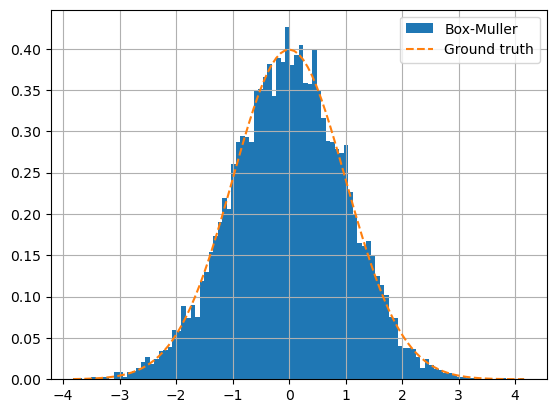

In [5]:
def normal_Box_Muller(mu=0, sigma=1 ,N=1):
    """
        Función para obtener muestras de la distribución normal con el método
        de Box-Muller
        
        mu: media de la normal
        sigma: varianza de la normal
        n: cantidad de puntos que devuelve 
        
        return: Devuelve un numpy array de n puntos con muestras de la distribución.
    """
    return mu + sigma * np.cos(2*np.pi*np.random.rand(N)) \
                *np.sqrt(-2*np.log(np.random.rand(N)))

x = normal_Box_Muller(mu=mu, sigma=sigma, N=N)
plot_histogram(x, mu=mu, sigma=sigma, nbins=nbins, label='Box-Muller')

Comparar los tiempos de ejecución de las tres funciones usando la función de Python `timeit`. Además, comparar el tiempo de ejecución de las tres funciones con el de la función `numpy.random.normal` de Python.

In [6]:
def normal_numpy(mu=0, sigma=1, N=1):
    return mu + sigma * np.random.randn(N)

mu, sigma = 0, 1
N = 100000
print("Normal from uniform")
%timeit normal_from_uniform(mu=mu, sigma=sigma, N=N, iters=12)
print("\nRejection sampling")
%timeit normal_rejection_sampling(mu=mu, sigma=sigma, N=N)
print("\nBox-Muller")
%timeit normal_Box_Muller(mu=mu, sigma=sigma, N=N)
print("\nNumpy")
%timeit normal_numpy(mu=mu, sigma=sigma, N=N)

Normal from uniform
4.77 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Rejection sampling
8 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Box-Muller
2.39 ms ± 7.54 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Numpy
1.26 ms ± 87.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## 2. Modelo de movimiento basado en odometrı́a

Implementar un modelo de movimiento basado en odometrı́a siguiendo estos pasos:

1. Crear una función en Python que implemente un modelo de movimiento basado en odometrı́a. Los tres argumentos de entrada deberán ser: 
$$
x_t = \begin{bmatrix} x \\ y \\ \theta \end{bmatrix} 
u_t = \begin{bmatrix} \delta_{r1} \\ \delta_{r2} \\  \delta_{t} \end{bmatrix} 
\alpha = \begin{bmatrix} \alpha_1 \\ \alpha_2 \\  \alpha_3 \\ \alpha_4 \end{bmatrix}
$$ 
donde $x_t$ es la pose actual del robot, $u_t$ es la lectura de odometrı́a obtenida por los sensores del robot y $\alpha$ son los parámetros de ruido del modelo de movimiento (varianza de la distribución). La función deberá devolver la nueva pose del robot $x_{t+1}$. 

La implementación de la función deberá incluir el error de obtención de la odometrı́a. Usar los métodos de muestreo del ejercicio 1 para generar muestras aleatorias normalmente distribuidas para introducir ruido en el modelo de movimiento.

In [7]:
def motion_model_odometry(xt, ut, a, sampling="numpy", N=1):

    if sampling == "numpy":
        f_normal = normal_numpy
    elif sampling == "uniform":
        f_normal = normal_from_uniform
    elif sampling == "rejection":
        f_normal = normal_rejection_sampling
    elif sampling == "box-muller":
        f_normal = normal_Box_Muller
    else:
        raise ValueError("Invalid sampling method")
    
    dr1 = f_normal(ut[0], a[0] * ut[0] + a[1] * ut[2], N)
    dr2 = f_normal(ut[1], a[0] * ut[1] + a[1] * ut[2], N)
    dt = f_normal(ut[2], a[2] * ut[2] + a[3] * (ut[0] + ut[1]), N)
    
    x1 = xt[0] + dt * np.cos(dr1+xt[2])
    y1 = xt[1] + dt * np.sin(dr1+xt[2])
    theta1 = xt[2] + dr1 + dr2
    
    return np.array([x1, y1, theta1])

2. Evaluar el modelo de movimiento desarrollado generando 5000 muestras con los siguientes argumentos:
$$
x_t = \begin{bmatrix} 2.0 \\ 4.0 \\ \frac{\pi}{2} \end{bmatrix} 
u_t = \begin{bmatrix} \frac{\pi}{4} \\ 0.0 \\  1.0 \end{bmatrix} 
\alpha = \begin{bmatrix} 0.1 \\ 0.1 \\  0.01 \\ 0.01 \end{bmatrix},
$$
Graficar las posiciones $(x_{t+1} , y_{t+1})$ para las 5000 muestras en un solo gráfico.

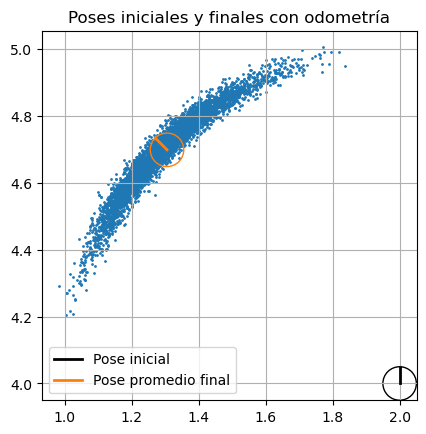

In [8]:
def plot_robot(xt, ax, radius=1, **kwargs):
    x, y, theta = xt
    circle = plt.Circle((x,y), radius, fill=False, color=kwargs.get('color', None))
    ax.add_artist(circle)
    ax.plot([x, x + radius * np.cos(theta)], [y, y + radius * np.sin(theta)], linewidth=2, **kwargs)


def plot_position(xt, xtplus1, radius=1):
    fig, ax = plt.subplots()
    plot_robot(xt, ax, radius=radius, color='k', label="Pose inicial")
    ax.scatter(xtplus1[0,:], xtplus1[1,:], color="tab:blue", s=1)
    plot_robot(xtplus1.mean(axis=1), ax, radius=radius, color='tab:orange', label="Pose promedio final")
    ax.grid(True)
    ax.set_title("Poses iniciales y finales con odometría")
    ax.set_aspect('equal', 'box')
    ax.legend()
    

N = 5000 # Cantidad de muestras
xt = np.array([2., 4., np.pi/2]) # Pose actual
ut = np.array([np.pi/4, 0., 1.]) # Odometría aplicada
a = np.array([.1, .1, .01, .01]) # Parámetros de ruido
xtplus1 = motion_model_odometry(xt, ut, a, sampling="numpy", N=N)
plot_position(xt, xtplus1, radius=.05)

---

## 3. Filtro Discreto

Queremos estimar la posición de un robot que se mueve en un mundo unidimensional acotado. El mundo tiene 20 celdas y el robot se encuentra inicialmente en la celda 10 (siendo la primer celda es la celda 0 y la ultima la 19). El robot no puede salir del area especificada. 

En cada paso, el robot puede ejecutar el comando "avanzar un paso" o "retroceder un paso". Este movimiento puede tener cierto error, por lo que el resultado puede no siempre ser el esperado. De hecho, el robot se comporta de la siguiente manera: al ejecutar "avanzar un paso" el resultado será el siguiente: 

* El 25% de las veces, el robot no se moverá.
* El 50% de las veces, el robot avanzará una celda.
* El 25% de las veces, el robot se moverá dos celdas.
* El robot en ningún caso se moverá en el sentido opuesto o avanzará más de dos celdas.

El modelo de "retroceder un paso" es similar, pero en el sentido opuesto. Ya que el mundo es acotado, el comportamiento al intentar "avanzar un paso" en los bordes es el siguiente:

* Si el robot está en la última celda, al tratar de avanzar se quedará en la misma celda el 100% de las veces.
* Si el robot está en la penúltima celda, al tratar de avanzar se quedará en la misma celda el 25% de las veces, y se moverá a la próxima celda el 75% de las veces.

Lo mismo sucederá en sentido contrario en el otro extremo del mundo al intentar retroceder.

Implementar un filtro de Bayes discreto en Python y estimar la posición final del robot (belief) después de ejecutar 9 comandos consecutivos de "avanzar un paso" y luego 3 comandos de "retroceder un paso". Graficar el belief resultante de la posición del robot. Comenzar con el belief inicial de
```Python
bel = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
```

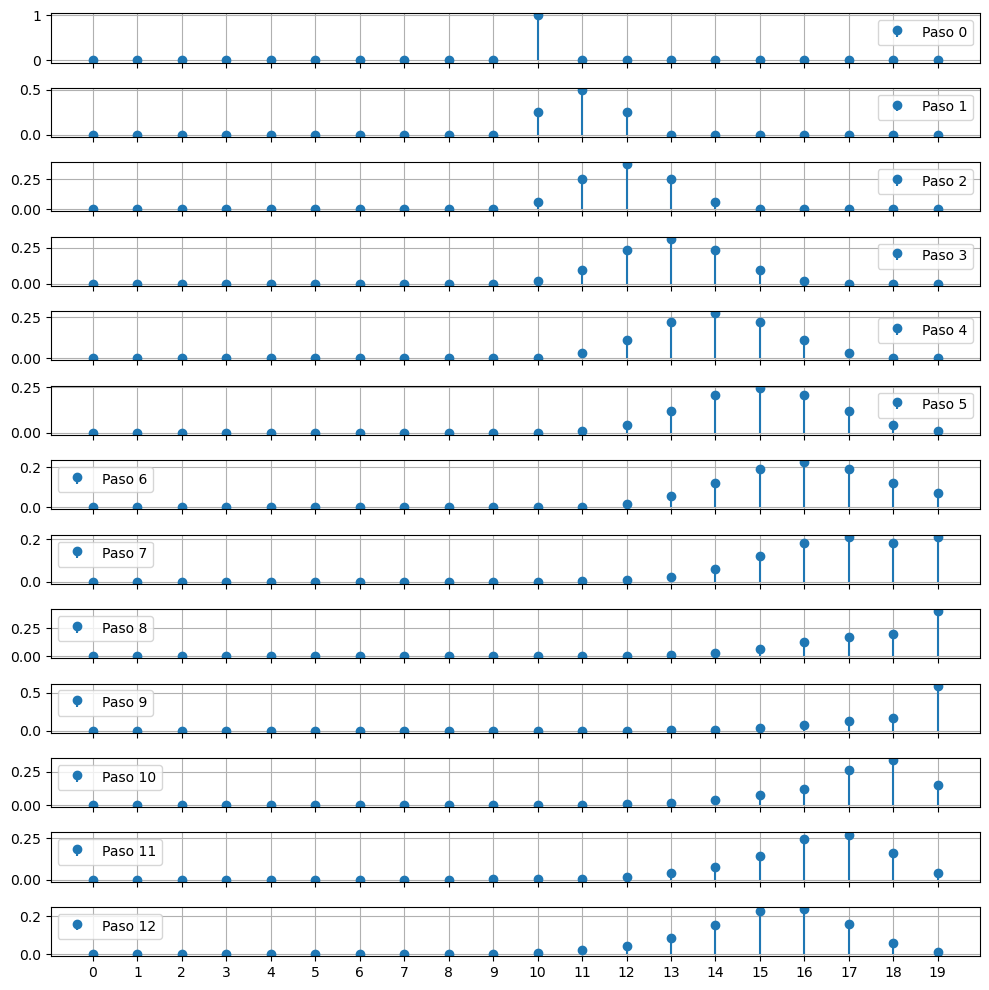

In [ ]:
from probotics import BayesFilter1D

Ncells = 20
initial_belief = np.zeros(Ncells)
initial_belief[10] = 1.
bf = BayesFilter1D(initial_belief, Ncells=Ncells)

# Aplicamos 9 pasos hacia adelante y 3 hacia atrás
odometry = ["forward"] * 9 + ["backward"] * 3
history = bf.fit(odometry)

fig, ax = plt.subplots(len(history), 1, figsize=(10, 10), sharex=True)
for i, b in enumerate(history):
    ax[i].stem(np.arange(Ncells), b, label=f"Paso {i}", basefmt=' ')
    ax[i].set_xticks(np.arange(Ncells))
    ax[i].grid(True)
    ax[i].legend()
fig.tight_layout()

## 4. Filtro de Partículas

En este ejercicio se implementará un filtro de partı́culas basándose en una estructura del código provista por la cátedra. La estructura provista contiene los modelos de movimiento y de medición, para que el esfuerzo del desarrollo sea en el filtro propiamente dicho. El módulo `probotics` contiene un directorio `localization` con la implementación de los diferentes filtros vistos en el curso. El archivo `particle_filter.py` contiene la clase `ParticleFilter` que es la base para la implementación del filtro de partículas. Dicha clase contine la siguiente estructura:
```Python
class ParticleFilter:

    def __init__(self, N, world_data_path, odometry_noise_params, measurement_noise, radius=0.5, seed=None):
        # Constructor de la clase que implementa el filtro
        # ...

    def prediction_step(self, odometry):
        # Implementación del paso de predicción
        for particle in self.particles:
            particle.apply_movement(odometry['r1'], odometry['t'], odometry['r2']) # Aplicamos odometría a cada partícula 

    def correction_step(self, sensor):
        # Implementación del paso de corrección
        new_weights = [
            w * self.sensor.measurement_prob_range(p.current_pose, sensor['id'], sensor['range'])
            for w, p in zip(self.weights, self.particles)
        ]
        self.weights = np.array(new_weights) / sum(new_weights)
        
    def systematic_resample(self):
        # Implementación del algoritmo de Muestreo Estocástico Universal
        # ...

    def update(self, odometry, sensor):
        # Actualización del filtro
        self.prediction_step(odometry) # predicción
        self.correction_step(sensor) # corrección
        self.systematic_resample() # remuestreo
    
    def get_mean_robot(self):
        # Función que obtiene la pose promedio de las partículas
        # ...
```

Un filtro de partı́culas consiste principalmente de tres pasos, tal como se ve en el método `update` de la clase anterior.
```Python
def update(self, odometry, sensor):
    # 1) Muestrear nuevas partículas usando el modelo de movimiento.
    self.prediction_step(odometry)
    
    # 2) Calcular el peso de las nuevas partículas usando el modelo de medición.
    self.correction_step(sensor)
    
    # 3) Calcular el nuevo belief muestreando las partículas de manera proporcional a sus pesos con reemplazo.
    self.systematic_resample() 
```
El método `prediction_step` está implementado en la estructura de código provista. En este ejercicio se deben implementar `correction_step` y `systematic_resample`.


Adicionalmente, se representa el sensor de distancia de landmarks en la clase `DeterministicLandmarkIdentificator`:
```Python
class DeterministicLandmarkIdentificator:

    def __init__(self, landmarks, sensor_noise):
        # ...

    def measurement_prob_range(self, current_pose, indices, ranges):
        # Calcula la probabilidad medir current_pose dadas las mediciones (indices, ranges)
        # ...
```

1. Completar la función `measurement_prob_range`. Esta función implementa el paso de actualización del filtro de partı́culas, usando un sensor de distancia. Toma como entrada *landmarks* (`world_data`) y observaciones de *landmarks* (*id* -identificación- y valor de distancia medida). La salida es un peso para cada partı́cula. En vez de calcular la probabilidad, es suficiente calcular el likelihood $p(z|x,l)$. El desvı́o estándar de la medición es $\sigma_r = 0.2$.

In [ ]:
from probotics import DeterministicLandmarkIdentificator
import numpy as np

sensor_noise = 0.2
sensor = DeterministicLandmarkIdentificator.from_file("../data/localization/world.dat", sensor_noise)
measurement = {
    "id": [1, 2],
    "range": [2.29725290252, 4.01825728983]
}
pose = np.array([0,0,0])

# Compute the probability of the measurmente
prob = sensor.measurement_prob_range(pose, measurement["id"], measurement["range"])
assert np.isclose(3.781184,prob)
print("Measurement model test passed!")

Measurement model test passed!


2. Completar el método `systematic_resample` implementando el Muestreo Estocástico Universal. La función toma como entrada un conjunto de partı́culas y sus correspondientes pesos y debe devolver otro conjunto de partı́culas.

In [29]:
from probotics import ParticleFilter

N = 10
sensor_data = "../data/localization/sensor_data.dat"
world_data = "../data/localization/world.dat"
odometry_noise_params = [0.1, 0.1, 0.05, 0.05]
sensor_noise = 0.2
seed = 1234
pf = ParticleFilter(N, world_data, odometry_noise_params, sensor_noise, radius=0.5, seed=seed)
for i, p in enumerate(pf.particles):
    p.current_pose = np.array([i, 2, 0])
pf.weights = np.array(
    [0.16373575, 0.13264105, 0.14185673, 0.04952149, 0.04505236, 0.06051621, 0.0820723 , 0.09715448, 0.15612917, 0.07132046]
)
pf.systematic_resample()
assert np.array_equal(pf.get_particles_poses(), np.array([
    [0, 2, 0], [1, 2, 0], [1, 2, 0], [2, 2, 0], [3, 2, 0],
    [5, 2, 0], [7, 2, 0], [8, 2, 0], [8, 2, 0],[9, 2, 0]
]))
print("Universal Stochastic Sample test passed!")

Universal Stochastic Sample test passed!


3. Se desea elegir una sola hipótesis del conjunto de partículas del filtro para representar la posición del robot. Implementar la función `get_mean_robot` que se usa para graficar la pose del robot. 

In [34]:
pf = ParticleFilter(N, world_data, odometry_noise_params, sensor_noise, radius=0.5, seed=seed)
for i, p in enumerate(pf.particles):
    p.current_pose = np.array([i, 2, 0])
pf.weights = np.array(
    [0.16373575, 0.13264105, 0.14185673, 0.04952149, 0.04505236, 0.06051621, 0.0820723 , 0.09715448, 0.15612917, 0.07132046]
)
robot = pf.get_mean_robot()
assert np.isclose(robot.current_pose, np.array([4.11114213, 2., 0.])).all()
print("Mean pose test passed!")

Mean pose test passed!


### 4.1 Visualización

Visualizar la implementación del filtro de partículas utilizando el siguiente código.

<IPython.core.display.Javascript object>


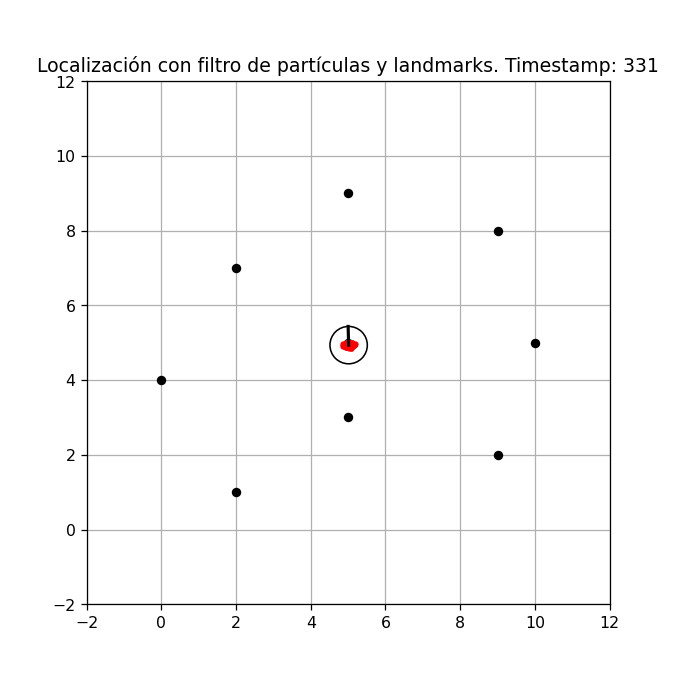

In [6]:
from probotics import ParticleFilter
from probotics.src.utils import read_sensor_data

def visualize_pf(N, sensor_data, world_data, odometry_noise_params, sensor_noise, seed):

    # Inicializamos el filtro de partículas
    pf = ParticleFilter(N, world_data, odometry_noise_params, sensor_noise, radius=0.5, seed=seed)
    poses = pf.get_particles_poses()
    mean_robot = pf.get_mean_robot()

    # Leemos los datos del sensor
    sensor_data = read_sensor_data(sensor_data)

    # Inicializamos el plot
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    plt.ion()
    fig.show()
    
    # Actualización del filtro de partículas y gráfico
    for t in range(len(sensor_data)):

        # Actualizamos el gráfico
        ax.cla()
        ax.set_xlim(-2, 12)
        ax.set_ylim(-2, 12)
        ax.set_aspect('equal')
        ax.grid(True)
        ax.set_title("Localización con filtro de partículas y landmarks. Timestamp: " + str(t))
        ax.plot(pf.sensor.landmarks['x'], pf.sensor.landmarks['y'], 'ko', markersize=5)
        ax.plot(poses[:,0], poses[:,1], 'r.')
        mean_robot.plot(ax, color='k')
        fig.canvas.draw()

        # Actualizamos el filtro de partículas
        pf.update(sensor_data[t]['odom'], sensor_data[t]['sensor'])
        
        # Obtenemos las poses de las partículas y la posición promedio
        poses = pf.get_particles_poses()
        mean_robot = pf.get_mean_robot()
        

    # Último gráfico
    ax.cla()
    ax.set_xlim(-2, 12)
    ax.set_ylim(-2, 12)
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_title("Localización con filtro de partículas y landmarks. Timestamp: " + str(len(sensor_data)))
    ax.plot(pf.sensor.landmarks['x'], pf.sensor.landmarks['y'], 'ko', markersize=5)
    ax.plot(poses[:,0], poses[:,1], 'r.')
    mean_robot.plot(ax, color='k')
    fig.canvas.draw()
    
N = 500
sensor_data = "../data/localization/sensor_data.dat"
world_data = "../data/localization/world.dat"
odometry_noise_params = [0.1, 0.1, 0.05, 0.05]
sensor_noise = 0.2
seed = 1234
visualize_pf(N, sensor_data, world_data, odometry_noise_params, sensor_noise, seed)